# Классификация символов
Задача заключается в определении символа.
Датасет изображений. Включает в себя набор изображений символов (0-9,A-Z,a-z) полученных из фотографий.
По ссылке доступны для скачивания изображения с символами на языке Каннада, его скачивать не нужно
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/,

### Мотивация

Распознавание символов - это классическая проблема распознавания образов для какие исследователи работали с первых дней компьютерной зрение. Сегодня камеры вездесущи, приложения автоматического распознавания символов шире, чем когда-либо. Для Латинским шрифтом, это в значительной степени считается решенной проблемой в ограниченные ситуации, такие как изображения отсканированных документов содержащие общие символьные шрифты и униформу задний план. Однако изображения, полученные с помощью популярных фотоаппаратов и портативные устройства по-прежнему представляют собой серьезную проблему для распознавание символов. Сложные аспекты этой проблемы очевидны в этом наборе данных.

In [ ]:
# # Загрузим архив с изображениями.
# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

# # распакуем архив.
# !tar -xvzf EnglishImg.tgz

In [31]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math
import os
from shutil import copyfile
from tqdm import tqdm
np.random.seed(1)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape,Dense,Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D,InputLayer

### Подготовка данных.

In [3]:
# Создадим список с именами классов. 
class_name = []

for i in range(ord('0'), ord('9')+1):
    class_name.append(chr(i))

for i in range(ord('A'), ord('Z')+1):
    class_name.append(chr(i))

for i in range(ord('a'), ord('z')+1):
    class_name.append(chr(i))

In [4]:
# Создадим дирректории для выборок train, test и validation.

if not os.path.isdir('dataset'):
  os.mkdir('dataset')

if not os.path.isdir('dataset/train'):
  os.mkdir('dataset/train')
if not os.path.isdir('dataset/valid'):
  os.mkdir('dataset/valid')
if not os.path.isdir('dataset/test'):
  os.mkdir('dataset/test')

In [5]:
for i in sorted(os.listdir('English/Img/GoodImg/Bmp')):
  if not os.path.isdir('dataset/train/'+i):
    os.mkdir('dataset/train/'+i)
  if not os.path.isdir('dataset/valid/'+i):
    os.mkdir('dataset/valid/'+i)
  if not os.path.isdir('dataset/test/'+i):
    os.mkdir('dataset/test/'+i)

In [6]:
# Распределеим фотографии с изображениями по созданным дирректориям.
# Рапределение изображений разных классов по папкам необходимо для
# использования ImageDataGenerator. 

base = 'English/Img/GoodImg/Bmp/Sample'
target_train = 'dataset/train/Sample'
target_test = 'dataset/test/Sample'
target_valid = 'dataset/valid/Sample'
randTrain_count=0
randValid_count=0
randTest_count=0

# Выборка содержит изображения символов (0-9,A-Z,a-z). В общей сложности - 62 класса.
for char  in tqdm(range(1, 63)): 
  classLen = len(os.listdir(base + str(char).zfill(3)))

# Размер тренировочной выборки = 80%, 
#        валидационной 15% 
#           тестовой = 5%.
  trainLen = math.floor(classLen*0.80)
  validLen = math.ceil(classLen*0.15)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)
  
  randTrain = randFnt[:trainLen]
  randValid = randFnt[trainLen : trainLen+validLen]
  randTest = randFnt[trainLen+validLen :]

  randTrain_count+=len(randTrain)
  randValid_count+=len(randValid)
  randTest_count+=len(randTest)

  for imgNo in randTrain:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png" 
    src = base + end_path #str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = target_train + end_path #'dataset/train/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randValid:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path #str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = target_valid + end_path #'dataset/valid/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randTest:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path #str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = target_test + end_path #'dataset/test/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

100%|██████████| 62/62 [00:00<00:00, 65.20it/s]


In [7]:
print('Размер выборок:')
print(f'Train: {randTrain_count}')
print(f'Test: {randTest_count}')
print(f'Valid: {randValid_count}')

Размер выборок:
Train: 6140
Test: 378
Valid: 1187


In [8]:
num_classes = 62
image_resize = 128
batch_size_training = 16
batch_size_validation = 16

### Инициализация ImageDataGenerator.

In [9]:
data_generator = ImageDataGenerator(rescale=1.0/255.0)

train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

test_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_validation,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 4255 images belonging to 62 classes.
Found 367 images belonging to 62 classes.
Found 1104 images belonging to 62 classes.


In [10]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)

    fig, axes = plt.subplots(1, num_of_images, 
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке. 
            )

    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):
      
        title_text = class_name[np.argmax(label_ind)]
        if true_ind is not None:
            title_text+=f' true = {class_name[np.argmax(true_ind[i])]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

In [11]:
# Проверим работу генератора.

batchX, batchy = train_generator.next()

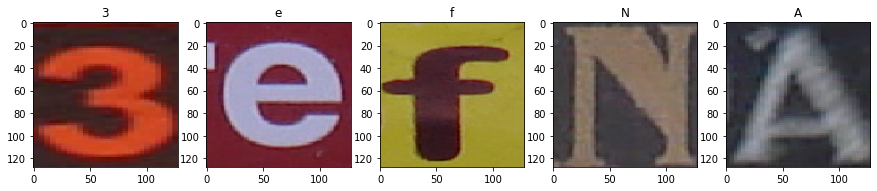

In [12]:
show_images(batchX[0:5], batchy[0:5])

### Строим модель. 

In [39]:
# конфигурирование слоев нейросети
model = Sequential()

model.add(InputLayer(input_shape = (128, 128, 3)))

model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(256,activation=Activation('relu')))
model.add(BatchNormalization())
model.add(Dense(256,activation=Activation('relu')))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation=Activation('softmax')))

model.summary()

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', #optimizer,
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 64)       

In [40]:
#parameters for fitting
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_testing = len(test_generator)
num_epochs = 100

In [41]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=10,
                              restore_best_weights=True)

In [42]:
#fit model
fit_history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = test_generator,
    validation_steps = steps_per_epoch_testing,
    callbacks = [early_stopping],
    # validation_batch_size=
    verbose = 1
)

Epoch 1/100
266/266 [==============================] - 10s 32ms/step - loss: 4.2817 - accuracy: 0.0897 - val_loss: 3.1267 - val_accuracy: 0.2725
Epoch 2/100
266/266 [==============================] - 8s 30ms/step - loss: 2.1827 - accuracy: 0.4678 - val_loss: 1.2924 - val_accuracy: 0.6866
Epoch 3/100
266/266 [==============================] - 8s 30ms/step - loss: 1.2518 - accuracy: 0.6603 - val_loss: 0.8127 - val_accuracy: 0.7956
Epoch 4/100
266/266 [==============================] - 8s 30ms/step - loss: 0.6993 - accuracy: 0.8110 - val_loss: 0.6390 - val_accuracy: 0.8420
Epoch 5/100
266/266 [==============================] - 8s 31ms/step - loss: 0.3845 - accuracy: 0.8978 - val_loss: 0.5516 - val_accuracy: 0.8501
Epoch 6/100
266/266 [==============================] - 8s 30ms/step - loss: 0.2714 - accuracy: 0.9273 - val_loss: 0.5888 - val_accuracy: 0.8420
Epoch 7/100
266/266 [==============================] - 8s 30ms/step - loss: 0.1791 - accuracy: 0.9574 - val_loss: 0.4974 - val_accuracy

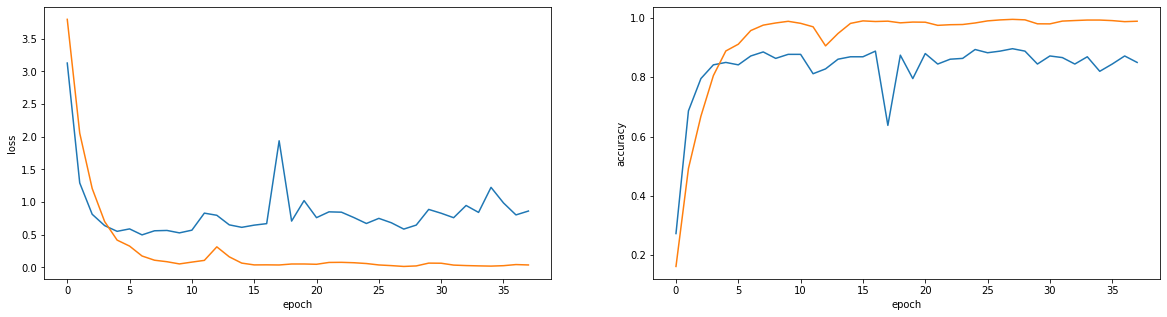

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].plot(fit_history.history['val_loss'], label='val_loss')
axes[0].plot(fit_history.history['loss'], label='loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
# axes[0].legend('val_loss')
# axes[0].set_yscale('log'),

axes[1].plot(fit_history.history['val_accuracy'], label='val_accuracy')
axes[1].plot(fit_history.history['accuracy'], label='accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
# axes[0].legend('val_accuracy')
# axes[1].set_yscale('log'),

plt.show()

In [52]:
#evaluate the model
eval = model.evaluate(test_generator, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.5858455896377563
accuracy for test dataset is : 0.8964577913284302


In [53]:
#evaluate the model
eval = model.evaluate(validation_generator, verbose=0)
print('Model performance:')
print('loss for validation dataset is : {}'.format(eval[0]))
print('accuracy for validation dataset is : {}'.format(eval[1]))

Model performance:
loss for validation dataset is : 0.8612792491912842
accuracy for validation dataset is : 0.8568840622901917


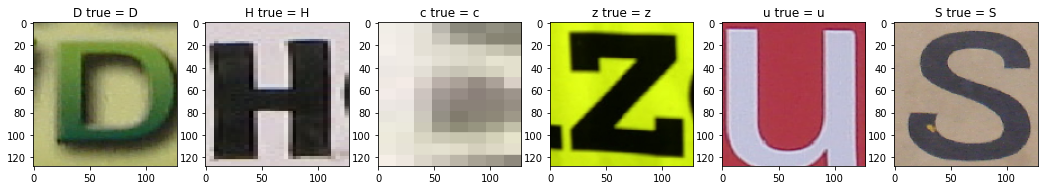

In [46]:
batchX, batchy = train_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

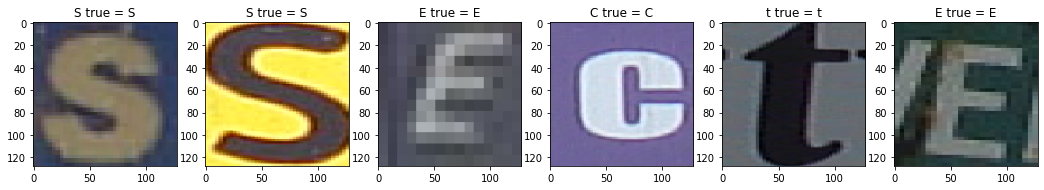

In [58]:
batchX, batchy = train_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

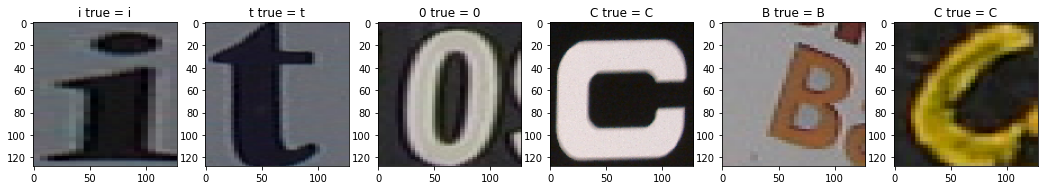

In [50]:
batchX, batchy = train_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

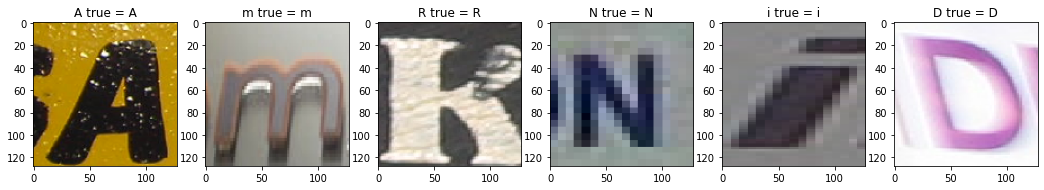

In [55]:
batchX, batchy = train_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

In [61]:
model.save_weights('Char74K.h5')